In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4387.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4255.jpg
/kaggle/

### Importing Necessary Libraries

In [21]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random


### Data Preprocessing

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

train_dataset = datasets.ImageFolder('/kaggle/input/cat-and-dog/training_set/training_set', transform = transform)
test_dataset = datasets.ImageFolder('/kaggle/input/cat-and-dog/test_set/test_set', transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualizing Images

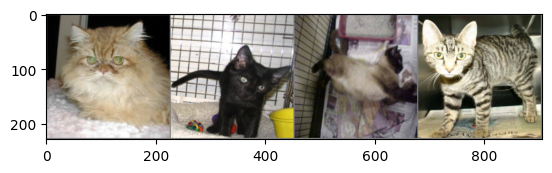

Cat   Cat   Cat   Cat  


In [23]:
classes = ['Cat', 'Dog']

def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

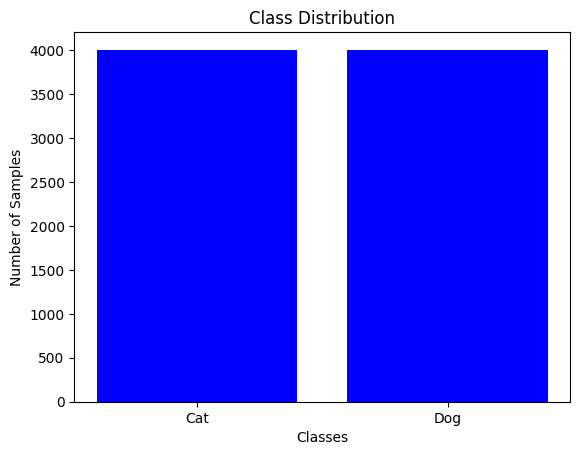

In [24]:
import matplotlib.pyplot as plt

def plot_class_distribution(dataset, classes):
    class_counts = {class_name: 0 for class_name in classes}
    
    # Count the number of samples for each class in the entire dataset
    for _, label in dataset:
        class_counts[classes[label]] += 1

    sorted_classes = sorted(classes)
    
    # Plot the bar chart
    plt.bar(sorted_classes, [class_counts[class_name] for class_name in sorted_classes], color='blue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(train_dataset, classes)


### Using ResNet18 To Train

In [30]:
import torch
import torch.nn as nn

# Basic Block for ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ResNet18(num_classes=2)

In [31]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

print(model)


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Epoch: 1/10 - Loss: 0.71834175613198
Epoch: 2/10 - Loss: 0.6896810121499337
Epoch: 3/10 - Loss: 0.6682731091350942
Epoch: 4/10 - Loss: 0.658611096672483
Epoch: 5/10 - Loss: 0.6405535801932528
Epoch: 6/10 - Loss: 0.6220588001471895
Epoch: 7/10 - Loss: 0.598818438877533
Epoch: 8/10 - Loss: 0.5614274339480595
Epoch: 9/10 - Loss: 0.5183143245426568
Epoch: 10/10 - Loss: 0.4797229290205788


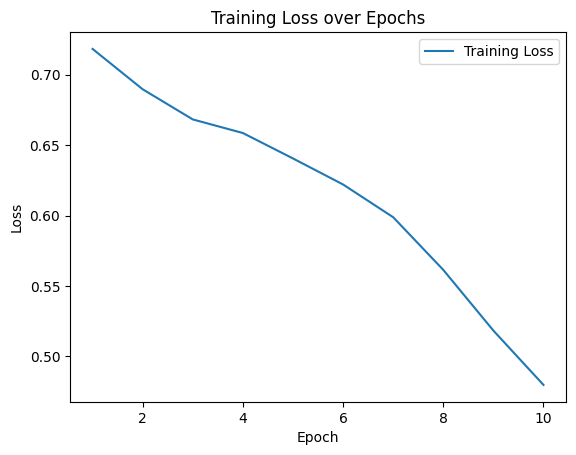

In [32]:
train_losses = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    
    print(f'Epoch: {epoch + 1}/{num_epochs} - Loss: {average_loss}')

import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

### Evaluating The Model

In [33]:
model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 78.00296589223925%


### Saving The Model

In [34]:
model_path = 'cats_dogs_classification.pth'

torch.save(model.state_dict(), model_path)

### Visualizing a few images and their labels

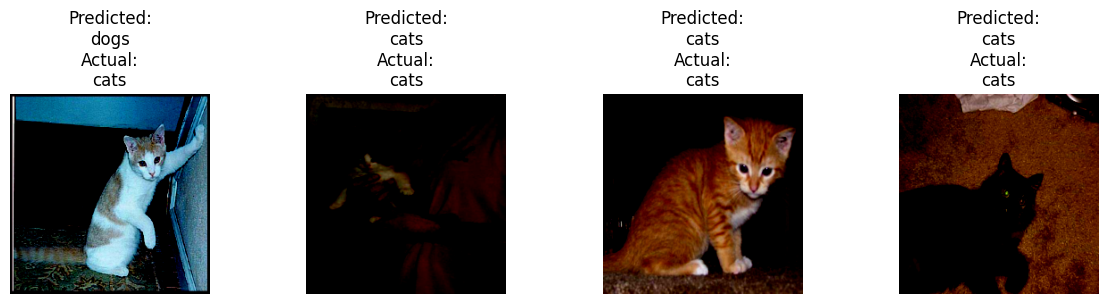

In [35]:
class_labels = {0: 'cats', 1: 'dogs'}

model.eval()

images, labels = next(iter(test_loader))

images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

num_images = len(images)
num_rows = num_images // 4  

fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
        ax.imshow(image)
        predicted_label = class_labels[predicted[i].item()]
        actual_label = class_labels[labels[i].item()]

        ax.set_title(f'Predicted:\n{predicted_label}\nActual:\n{actual_label}')
        ax.axis('off')

plt.tight_layout()
plt.show()

### Plotting Confusion Matrix on Heatmap

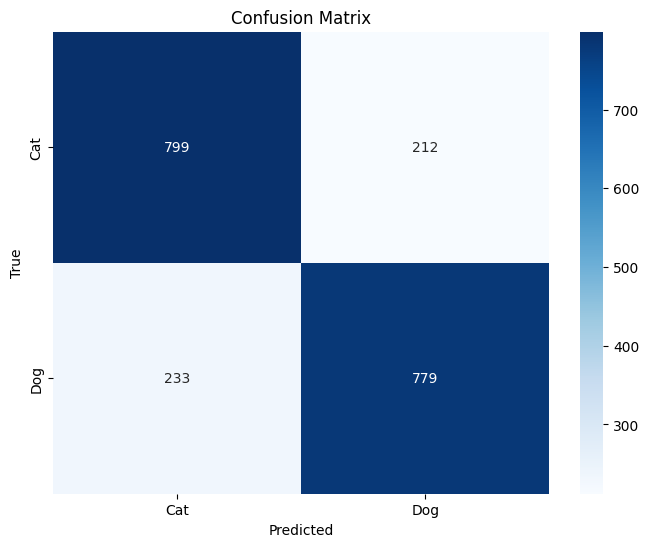

In [36]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
import numpy as np
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_images(images, target_size):
    processed_images = []
    for image in images:
        resized_image = transform.resize(image, target_size, mode='constant')
        flattened_image = resized_image.flatten()
        processed_images.append(flattened_image)
    return np.array(processed_images)

cat_images = io.ImageCollection('/kaggle/input/cat-and-dog/training_set/training_set/cats/*.jpg')
dog_images = io.ImageCollection('/kaggle/input/cat-and-dog/training_set/training_set/dogs/*.jpg')

cat_images_test = io.ImageCollection('/kaggle/input/cat-and-dog/test_set/test_set/cats/*.jpg')
dog_images_test = io.ImageCollection('/kaggle/input/cat-and-dog/test_set/test_set/dogs/*.jpg')

target_size = (64, 64)

cat_images = preprocess_images(cat_images, target_size)
dog_images = preprocess_images(dog_images, target_size)

cat_images_test = preprocess_images(cat_images_test, target_size)
dog_images_test = preprocess_images(dog_images_test, target_size)

cat_labels = np.zeros(len(cat_images))
dog_labels = np.ones(len(dog_images))
X_train = np.vstack((cat_images, dog_images))
y_train = np.concatenate((cat_labels, dog_labels))

cat_labels_test = np.zeros(len(cat_images_test))
dog_labels_test = np.ones(len(dog_images_test))
X_test = np.vstack((cat_images_test, dog_images_test))
y_test = np.concatenate((cat_labels_test, dog_labels_test))

# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0, random_state=42)  # Shuffle training data
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=0, random_state=42)  # Shuffle test data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

input_size = X_train.shape[1]
hidden_size = 128
output_size = 1

np.random.seed(42)
weights_hidden = np.random.randn(input_size, hidden_size)
biases_hidden = np.zeros((1, hidden_size))
weights_output = np.random.randn(hidden_size, output_size)
biases_output = np.zeros((1, output_size))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

learning_rate = 0.01
epochs = 1000

for epoch in range(epochs):
    hidden_layer_input = np.dot(X_train, weights_hidden) + biases_hidden
    hidden_layer_output = sigmoid(hidden_layer_input)
    
    output_layer_input = np.dot(hidden_layer_output, weights_output) + biases_output
    predicted_output = sigmoid(output_layer_input)
    
    error = y_train.reshape(-1, 1) - predicted_output
    loss = 0.5 * np.mean(error ** 2)

    output_error = error * sigmoid_derivative(predicted_output)
    hidden_layer_error = output_error.dot(weights_output.T) * sigmoid_derivative(hidden_layer_output)
    
    weights_output += learning_rate * hidden_layer_output.T.dot(output_error)
    biases_output += learning_rate * np.sum(output_error, axis=0, keepdims=True)
    weights_hidden += learning_rate * X_train.T.dot(hidden_layer_error)
    biases_hidden += learning_rate * np.sum(hidden_layer_error, axis=0, keepdims=True)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

hidden_layer_input_test = np.dot(X_test, weights_hidden) + biases_hidden
hidden_layer_output_test = sigmoid(hidden_layer_input_test)
output_layer_input_test = np.dot(hidden_layer_output_test, weights_output) + biases_output
predicted_output_test = sigmoid(output_layer_input_test)

binary_predictions = (predicted_output_test > 0.5).astype(int)

accuracy = np.mean(binary_predictions == y_test.reshape(-1, 1))
print(f"Accuracy on test set: {accuracy * 100}%")


/tmp/ipykernel_47/1898683455.py:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 0, Loss: 0.2438640973244084
Epoch 100, Loss: 0.13403990717522568
Epoch 200, Loss: 0.09716739096945386
Epoch 300, Loss: 0.053650703308862645
Epoch 400, Loss: 0.1094369656059967
Epoch 500, Loss: 0.0639812418225347
Epoch 600, Loss: 0.01541195019492586
Epoch 700, Loss: 0.015131151774379903
Epoch 800, Loss: 0.014705522429328866
Epoch 900, Loss: 0.014525836921657148
Accuracy on test set: 55.75877409787444%


In [ ]:

import numpy as np
from skimage import io, transform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, epochs=1000, random_seed=42):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs

        np.random.seed(random_seed)
        self.weights_hidden = np.random.randn(input_size, hidden_size)
        self.biases_hidden = np.zeros((1, hidden_size))
        self.weights_output = np.random.randn(hidden_size, output_size)
        self.biases_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def fit(self, X_train, y_train):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        for epoch in range(self.epochs):
            hidden_layer_input = np.dot(X_train_scaled, self.weights_hidden) + self.biases_hidden
            hidden_layer_output = self.sigmoid(hidden_layer_input)

            output_layer_input = np.dot(hidden_layer_output, self.weights_output) + self.biases_output
            predicted_output = self.sigmoid(output_layer_input)

            error = y_train.reshape(-1, 1) - predicted_output
            loss = 0.5 * np.mean(error ** 2)

            output_error = error * self.sigmoid_derivative(predicted_output)
            hidden_layer_error = output_error.dot(self.weights_output.T) * self.sigmoid_derivative(hidden_layer_output)

            self.weights_output += self.learning_rate * hidden_layer_output.T.dot(output_error)
            self.biases_output += self.learning_rate * np.sum(output_error, axis=0, keepdims=True)
            self.weights_hidden += self.learning_rate * X_train_scaled.T.dot(hidden_layer_error)
            self.biases_hidden += self.learning_rate * np.sum(hidden_layer_error, axis=0, keepdims=True)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X_test):
        scaler = StandardScaler()
        X_test_scaled = scaler.transform(X_test)

        hidden_layer_input_test = np.dot(X_test_scaled, self.weights_hidden) + self.biases_hidden
        hidden_layer_output_test = self.sigmoid(hidden_layer_input_test)
        output_layer_input_test = np.dot(hidden_layer_output_test, self.weights_output) + self.biases_output
        predicted_output_test = self.sigmoid(output_layer_input_test)

        binary_predictions = (predicted_output_test > 0.5).astype(int)
        return binary_predictions


X_train_combined = np.vstack((cat_images, dog_images))
y_train_combined = np.concatenate((np.zeros(len(cat_images)), np.ones(len(dog_images))))

X_test_combined = np.vstack((cat_images_test, dog_images_test))
y_test_combined = np.concatenate((np.zeros(len(cat_images_test)), np.ones(len(dog_images_test))))

X_train, X_val, y_train, y_val = train_test_split(X_train_combined, y_train_combined, test_size=0.2, random_state=42)

nn = SimpleNeuralNetwork(input_size=X_train.shape[1], hidden_size=128, output_size=1, learning_rate=0.01, epochs=1000)

nn.fit(X_train, y_train)

predictions = nn.predict(X_test_combined)

accuracy = np.mean(predictions == y_test_combined.reshape(-1, 1))
print(f"Accuracy on test set: {accuracy * 100}%")

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

predicted_probabilities = sigmoid(output_layer_input_test)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

top1_accuracy = accuracy_score(y_test, predicted_labels)

top5_accuracy = 0  

conf_matrix = confusion_matrix(y_test, predicted_labels)

roc_auc = roc_auc_score(y_test, predicted_probabilities)
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)

precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

tp = conf_matrix[1, 1]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]
fn = conf_matrix[1, 0]

print(f"Top1 Accuracy: {top1_accuracy * 100}%")
print(f"Top5 Accuracy: {top5_accuracy * 100}%")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"AUC-ROC Score: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"True Positive (TP): {tp}")
print(f"False Positive (FP): {fp}")
print(f"True Negative (TN): {tn}")
print(f"False Negative (FN): {fn}")


Top1 Accuracy: 55.75877409787444%
Top5 Accuracy: 0%
Confusion Matrix:
[[569 442]
 [453 559]]
AUC-ROC Score: 0.5817792816567169
Precision: 0.5584415584415584
Recall: 0.5523715415019763
F1 Score: 0.5553899652260308
True Positive (TP): 559
False Positive (FP): 442
True Negative (TN): 569
False Negative (FN): 453


In [47]:
print("Cat image shape:", cat_images[0].shape)
print("Dog image shape:", dog_images[0].shape)

Cat image shape: (12288,)
Dog image shape: (12288,)


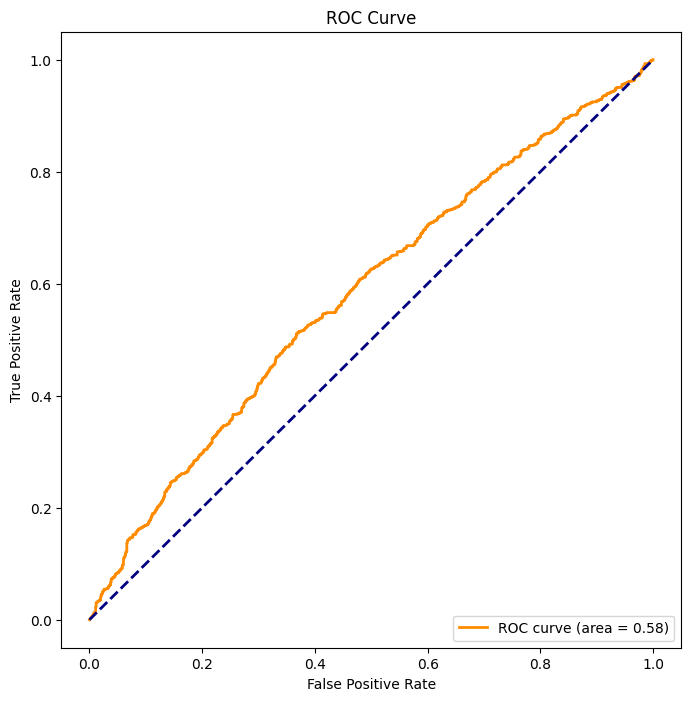

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


/tmp/ipykernel_47/2102521582.py:55: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


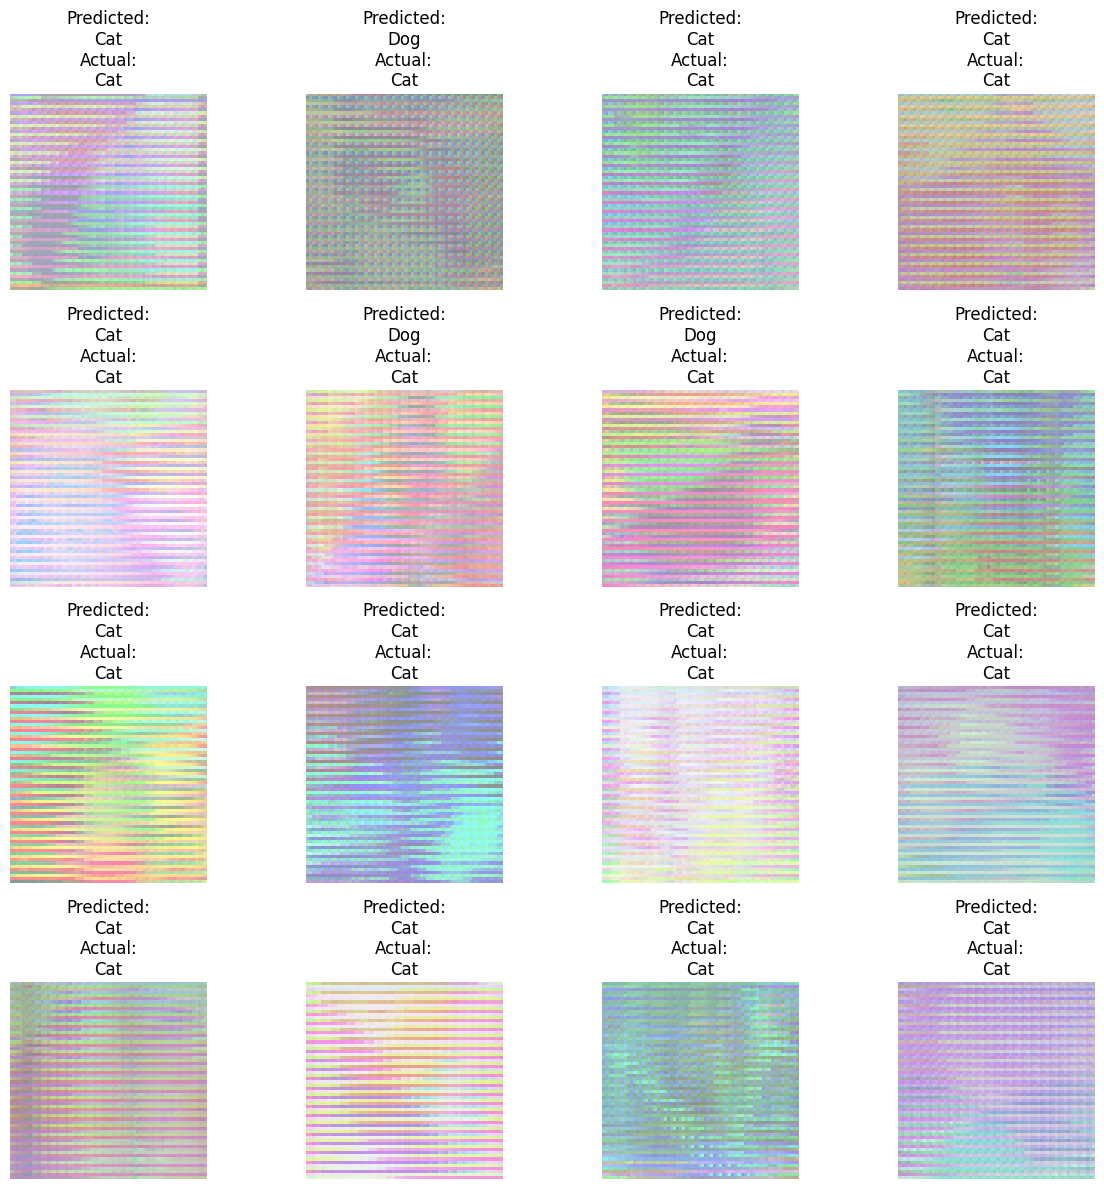

In [40]:
hidden_layer_input_test_tensor = torch.from_numpy(X_test).float().mm(weights_hidden_tensor) + biases_hidden_tensor
hidden_layer_output_test_tensor = sigmoid(hidden_layer_input_test_tensor)
predicted_probabilities = sigmoid(hidden_layer_output_test_tensor)
predicted_labels = (predicted_probabilities > 0.5).int()

num_images = min(16, len(X_test))
num_rows = num_images // 4

fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        # Reshape and normalize the image
        image_flat = X_test[i]
        image = image_flat.reshape((3, 64, 64)) / 2 + 0.5
        image = np.transpose(image, (1, 2, 0))  # Transpose to (64, 64, 3) for displaying

        ax.imshow(image)
        predicted_label = class_labels[predicted_labels[i, 0].item()]  # Extracting the item from the tensor
        actual_label = class_labels[int(y_test[i])]

        ax.set_title(f'Predicted:\n{predicted_label}\nActual:\n{actual_label}')
        ax.axis('off')

plt.tight_layout()
plt.show()